### Import all dependencies

In [28]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

### Define Few Parameters

In [29]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 100
batch_size = 32

#define paths
TB_path = '/home/taherizade/Sajid Ali Final Project/Project Codes/MainCode MEdi Image Analysis/imgs/tb'
nonTB_path = '/home/taherizade/Sajid Ali Final Project/Project Codes/MainCode MEdi Image Analysis/imgs/test'

# Use glob to grab images from path .jpg or jpeg
TB_files = glob(TB_path + '/*')
nonTB_files = glob(nonTB_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [30]:
# Preparing Labels
TB_labels = []
nonTB_labels = []

TB_images=[]
nonTB_images=[]

import cv2 

for i in range(len(TB_files)):
  image = cv2.imread(TB_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  TB_images.append(image)
  TB_labels.append('tb')
for i in range(len(nonTB_files)):
  image = cv2.imread(nonTB_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  nonTB_images.append(image)
  nonTB_labels.append('test')

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Visualize First 40 Images from Data set

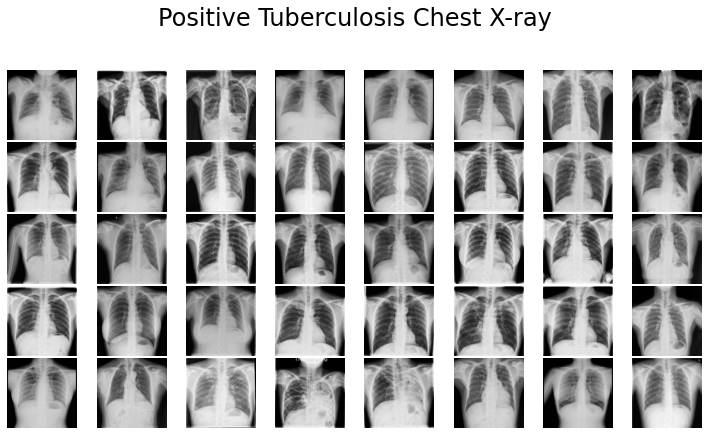

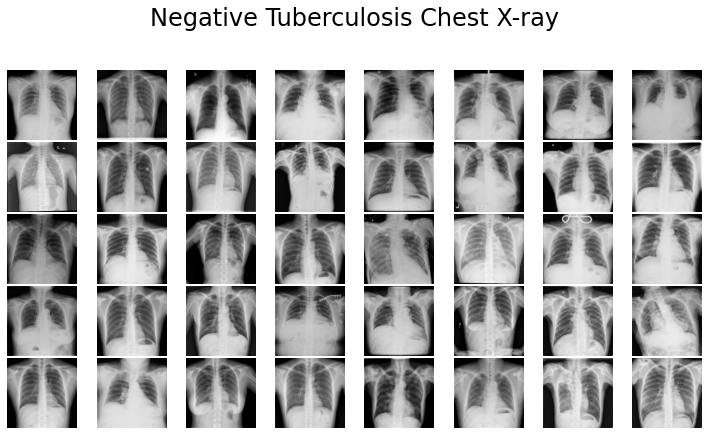

In [26]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(TB_images, 'Positive Tuberculosis Chest X-ray')
plot_images(nonTB_images, 'Negative Tuberculosis Chest X-ray')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [7]:
# Convert to array and Normalize to interval of [0,1]
TB_images = np.array(TB_images) / 255
nonTB_images = np.array(nonTB_images) / 255

### **Train Test Split**

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
TB_x_train, TB_x_test, TB_y_train, TB_y_test = train_test_split(
    TB_images, TB_labels, test_size=0.2)
nonTB_x_train, nonTB_x_test, nonTB_y_train, nonTB_y_test = train_test_split(
    nonTB_images, nonTB_labels, test_size=0.2)


X_train = np.concatenate((nonTB_x_train, TB_x_train), axis=0)
X_test = np.concatenate((nonTB_x_test, TB_x_test), axis=0)
y_train = np.concatenate((nonTB_y_train, TB_y_train), axis=0)
y_test = np.concatenate((nonTB_y_test, TB_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

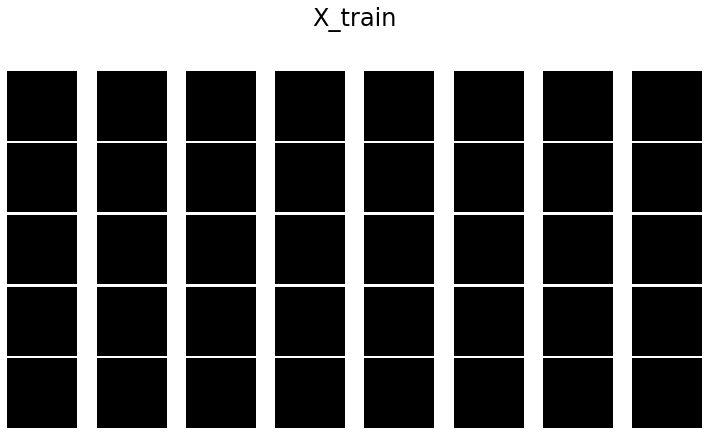

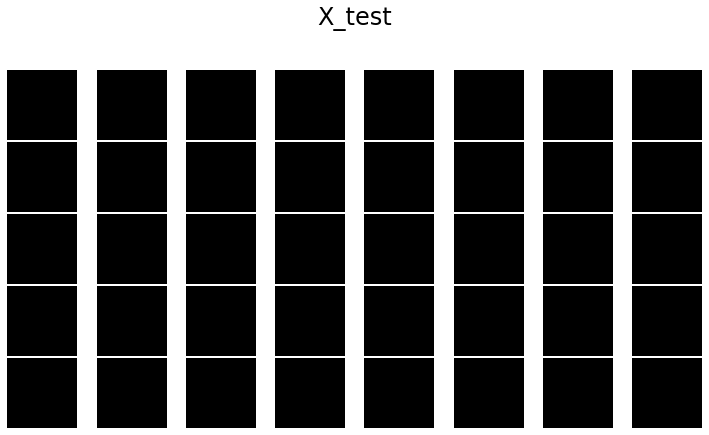

In [27]:
plot_images(TB_x_train, 'X_train')
plot_images(TB_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [10]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### **Image Augmentation**
To train on images at different positions, angles, flips, etc

In [12]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [13]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=100)

Epoch 1/100
58/58 [==============================] - 23s 289ms/step - loss: 0.9433 - accuracy: 0.5722 - val_loss: 0.6406 - val_accuracy: 0.6610
Epoch 2/100
58/58 [==============================] - 13s 211ms/step - loss: 0.8302 - accuracy: 0.5727 - val_loss: 0.6415 - val_accuracy: 0.6610
Epoch 3/100
58/58 [==============================] - 12s 205ms/step - loss: 0.7664 - accuracy: 0.6024 - val_loss: 0.6435 - val_accuracy: 0.6610
Epoch 4/100
58/58 [==============================] - 13s 213ms/step - loss: 0.7512 - accuracy: 0.5807 - val_loss: 0.6454 - val_accuracy: 0.6610
Epoch 5/100
58/58 [==============================] - 12s 209ms/step - loss: 0.7231 - accuracy: 0.6008 - val_loss: 0.6758 - val_accuracy: 0.6610
Epoch 6/100
58/58 [==============================] - 13s 214ms/step - loss: 0.7452 - accuracy: 0.5897 - val_loss: 0.6475 - val_accuracy: 0.6610
Epoch 7/100
58/58 [==============================] - 13s 211ms/step - loss: 0.8061 - accuracy: 0.5706 - val_loss: 0.9178 - val_accuracy:

58/58 [==============================] - 12s 206ms/step - loss: 0.7689 - accuracy: 0.5886 - val_loss: 0.6473 - val_accuracy: 0.6610
Epoch 58/100
58/58 [==============================] - 12s 204ms/step - loss: 0.7440 - accuracy: 0.6014 - val_loss: 0.6279 - val_accuracy: 0.6610
Epoch 59/100
58/58 [==============================] - 12s 204ms/step - loss: 0.7565 - accuracy: 0.5886 - val_loss: 0.6440 - val_accuracy: 0.6610
Epoch 60/100
58/58 [==============================] - 12s 205ms/step - loss: 0.7717 - accuracy: 0.6019 - val_loss: 0.6250 - val_accuracy: 0.6610
Epoch 61/100
58/58 [==============================] - 12s 208ms/step - loss: 0.7523 - accuracy: 0.6062 - val_loss: 0.8575 - val_accuracy: 0.6610
Epoch 62/100
58/58 [==============================] - 13s 213ms/step - loss: 0.7992 - accuracy: 0.5791 - val_loss: 0.6574 - val_accuracy: 0.6610
Epoch 63/100
58/58 [==============================] - 12s 210ms/step - loss: 0.7773 - accuracy: 0.5886 - val_loss: 0.6266 - val_accuracy: 0.661

In [14]:
model.save('vgg_chest.h5')

In [15]:
model.save_weights('vggweights_chest.hdf5')

In [16]:
model = load_model('vgg_chest.h5')

### **Making Predicions**

In [17]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

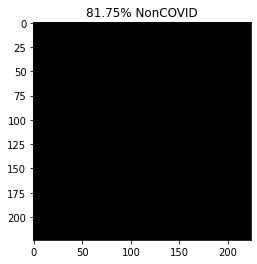

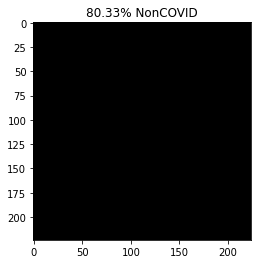

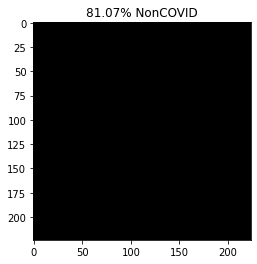

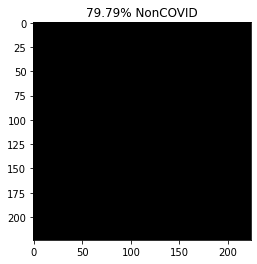

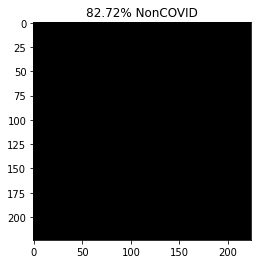

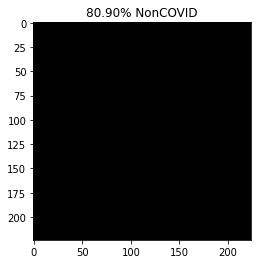

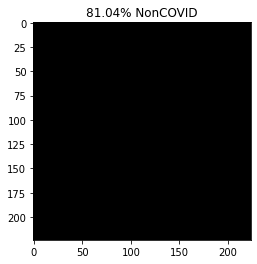

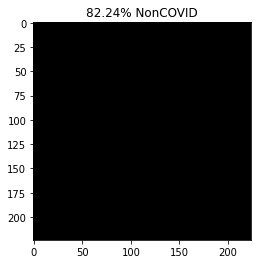

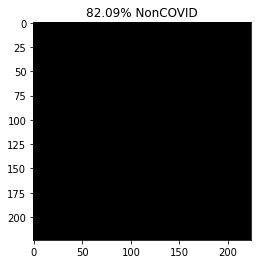

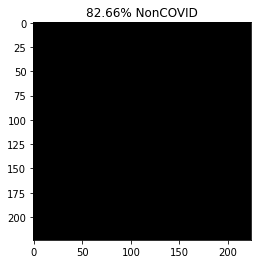

In [18]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [19]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

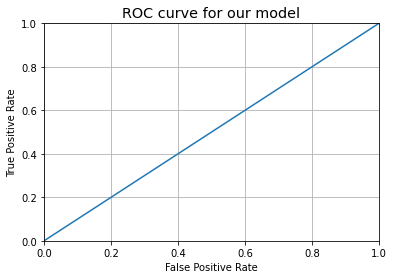

In [20]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


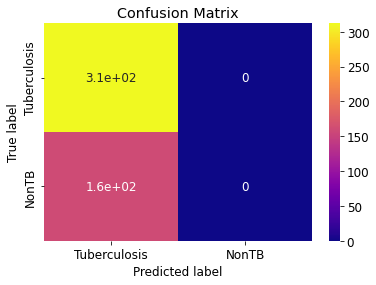

Confusion Matrix with Normalized Values


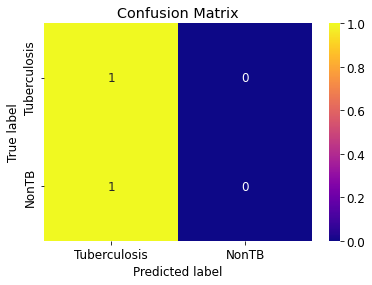

In [21]:
def plot_confusion_matrix(normalize):
  classes = ['Tuberculosis','NonTB']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.66      1.00      0.80       312
           1       0.00      0.00      0.00       160

    accuracy                           0.66       472
   macro avg       0.33      0.50      0.40       472
weighted avg       0.44      0.66      0.53       472



/home/taherizade/anaconda3/envs/Sajid/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherizade/anaconda3/envs/Sajid/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/taherizade/anaconda3/envs/Sajid/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

### **Accuracy and Loss Plots**

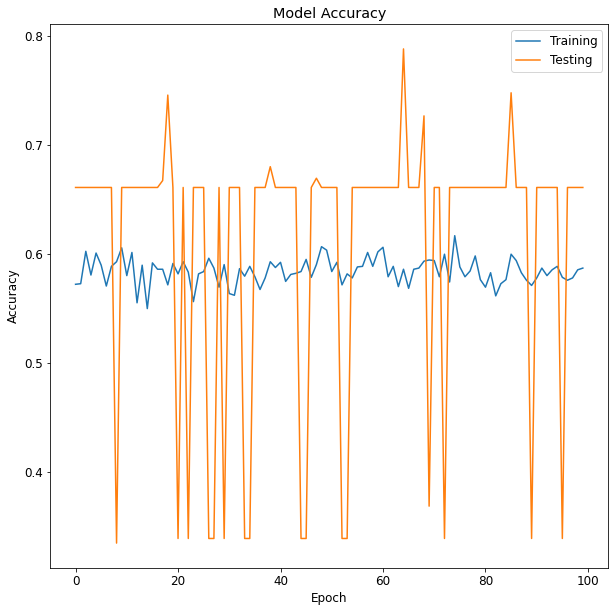

In [23]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()


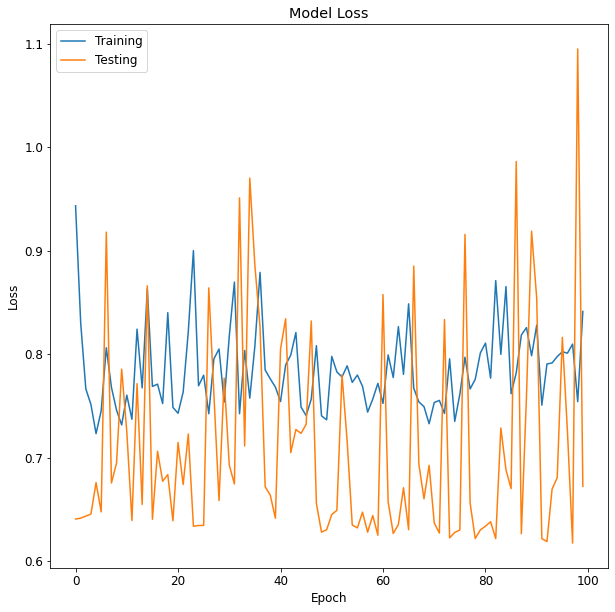

In [24]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()